### Задача

Реализовать на Python алгоритм, выбирающий рекламные блоки для размещения рекламных роликов Clip1 и Clip2 с учётом свободного места в рекламных блоках и максимизирующий сумму целевых рейтингов (поле TargetRate) выбранных блоков с учётом следующих ограничений:

    1. Ролик Clip1 должен быть размещён на 100 рейтингов (сумма по колонке BlockRate), причём 58-60% размещения (58-60 рейтингов) должно быть размещено в прайм-тайм (IsPrime = 1). Допустимое отклонение размещения по рейтингам ±2%.

    2. Ролик Clip2 должен быть размещён на 60 рейтингов (сумма по колонке BlockRate), причём 48-50% размещения (28.8-30 рейтингов) должно быть размещено в прайм-тайм (IsPrime = 1). Допустимое отклонение размещения по рейтингам ±2%.

    3. Общая сумма размещения по двум роликам должна быть равна 750 рублям. Допустимое отклонение бюджета в меньшую сторону – 5 рублей. В большую сторону отклонение недопустимо.

    4. Ролики должны быть максимально равномерно распределены по всему месяцу размещения.


### 0. Загружаем необходимые библиотеки

In [2]:
import numpy as np
import pandas as pd

import datetime as dt

%matplotlib inline
import matplotlib.pyplot as plt

#normality distribution test
from scipy.stats import skewtest, skew, kurtosis

#set path to data
PATH = "..."
import os
os.chdir(PATH)

### 1. Алгоритм А

Оптимизация происходит последовательно по каждому дню месяца начиная с первого дня. Остаток рейтингов переносится на следующий день. Данный подход был разработан с целью сохранения нормального распределения рейтингов внутри месяца, однако, как показал дальнейший анализ, а именно второй подход (алгоритм В - распределение сразу по всему месяцу), необходимости использования такого "аккуратного" подхода в данном сценарии нет.

Краткое описание принципа

    о определяем исходный вес дня ClipDayWeight (сколько рейтингов в день необходимо использовать)
    о создаем словрь BlockInxToUse вида день (ключ), индексы BlockId (значения) - результат функции
    о цикл для каждого дня - слабое место, если, к примеру, месяцев будет несколько (на данном этапе стоит задача оптимизации внутри 1 месяца)
    о добавляем остаток от предыдущего дня DayResid (может быть положительный и отрицательный)
    о проверка на отрицательность - если отрицательное значение, то добавлем дневной вес и переходим к следующему дню
    о основной расчет: создаем вектор BlockRateSorted, который содержит отсортированные по Affinity (TargetRate/BlockRate) рейтинги BlockRate, находим минимальное значение разницы по модулю накопленных значений вектора BlockRateSorted и ClipDayWeightAdj
    о сохраняем остаток рейтингов в DayResid
    o запоминаем позицию минимум и записываем ее в IndexMinDevPos
    o добавляем в словарь индексы BlockId, которые будем использовать
    o удаляем забукированное время под наш клип из исходного файла
    o возвращаем словарь с результатами

In [3]:
def AdBlockSelector(Data, GRP, PrimeShare, IsPrime, ClipLen):

    """
    Description: select optimal TV Ad Blocks
    
    Parameters:
        o Data - initial dataframe
        o GRP - total GRP amount for selected Clip [integer]
        o PrimeShare - share of Prime [float]
        o IsPrime - True or False. True if we optimize Prime [boolean]
        o ClipLen - duration of Clip
        
    Output: dictionary where keys are days of the month and values are BlockID indexes from initial dataframe 
    """
    
    
    if IsPrime:
        ClipDayWeight = GRP * (PrimeShare) / Data['Day'].max()   #weak
    else:
        ClipDayWeight = GRP * (1-PrimeShare) / Data['Day'].max()   #weak

    BlockIdxToUse = {}
    DayResid = 0

    for day in Data['Day'].unique():     #weak
    
        ClipDayWeightAdj = ClipDayWeight - DayResid
    
    
        if ClipDayWeightAdj <= 0:
            DayResid = DayResid - ClipDayWeight
        
    

    
        else:
            BlockRateSorted = Data[(Data['IsPrime'] == IsPrime) & 
                                   (Data['Day'] == day) & 
                                   (Data['AvailableSeconds'] >= ClipLen)].sort_values(
            ['Day', 'Affinity'], ascending=False)['BlockRate']
    
            IndexMinDev = np.argmin( np.abs( BlockRateSorted.cumsum() - ClipDayWeightAdj ) )
            DayResid = ( BlockRateSorted.cumsum() - ClipDayWeightAdj )[IndexMinDev]
            IndexMinDevPos = list(BlockRateSorted.index).index(IndexMinDev)
    
            BlockIdxToUse[day] = list(BlockRateSorted.index)[:IndexMinDevPos + 1]

            Data.loc[list(BlockIdxToUse[day]), 'AvailableSeconds'] = (Data.loc[list(BlockIdxToUse[day]), 'AvailableSeconds'] 
                                                                  - ClipLen).values
    
    return BlockIdxToUse

### 1.1. Задаем исходные параметры, загружаем датасет

In [4]:
#Clip duration
Clip1Len = 30
Clip2Len = 30

#GRP value
Clip1GRP = 100
Clip2GRP = 60

#share of Prime
Clip1PrimeShare = 0.59
Clip2PrimeShare = 0.49

#price of 1 BlockRate
PrimeCPP = 6
NonPrimeCPP = 3

#download the file
FILE = 'TvBreaksData_toSend.xlsx'
data = pd.read_excel(PATH + '\\' + FILE)

#a few steps of preprocessing
data['BlockDateTimeShifted'] = ( data['BlockDateTime'] - dt.timedelta(hours=6) )
data['Day'] = data['BlockDateTimeShifted'].dt.day
data['Affinity'] = (data['TargetRate'] / data['BlockRate'])

### 1.2. Запускаем функцию, получаем результаты

In [5]:
#collect blockid numbers by days of month for specific clip with prime option (off/on)
Clip1PrimeDic = AdBlockSelector(Data=data, GRP=Clip1GRP, PrimeShare=Clip1PrimeShare, IsPrime=True, ClipLen=Clip1Len)
Clip1NonPrimeDic = AdBlockSelector(Data=data, GRP=Clip1GRP, PrimeShare=Clip1PrimeShare, IsPrime=False, ClipLen=Clip1Len)
Clip2PrimeDic = AdBlockSelector(Data=data, GRP=Clip2GRP, PrimeShare=Clip2PrimeShare, IsPrime=True, ClipLen=Clip1Len)
Clip2NonPrimeDic = AdBlockSelector(Data=data, GRP=Clip2GRP, PrimeShare=Clip2PrimeShare, IsPrime=False, ClipLen=Clip1Len)

In [6]:
Clip1PrimeId = [item for sublist in pd.Series(Clip1PrimeDic).values for item in sublist]
Clip1NonPrimeId = [item for sublist in pd.Series(Clip1NonPrimeDic).values for item in sublist]
Clip2PrimeId = [item for sublist in pd.Series(Clip2PrimeDic).values for item in sublist]
Clip2NonPrimeId = [item for sublist in pd.Series(Clip2NonPrimeDic).values for item in sublist]

In [7]:
#CPP is a constant 
print("Spend RUR: ",
( (PrimeCPP * Clip1GRP * Clip1PrimeShare) + (NonPrimeCPP * Clip1GRP * (1-Clip1PrimeShare)) +
 (PrimeCPP * Clip2GRP * Clip2PrimeShare) + (NonPrimeCPP * Clip2GRP * (1-Clip2PrimeShare)) ) )

Spend RUR:  745.1999999999999


In [8]:
print("Num of Spots",
( len( Clip1PrimeId ) * PrimeCPP +
 len( Clip1NonPrimeId ) * NonPrimeCPP +
 len( Clip2PrimeId ) * PrimeCPP +
 len( Clip2NonPrimeId ) * NonPrimeCPP ) )

Num of Spots 753


In [9]:
print("Clip1 Prime BlockRate: ", 
      data.loc[ Clip1PrimeId ]['BlockRate'].sum(),
      "Clip1 Prime TargetRate: ", 
      data.loc[ Clip1PrimeId ]['TargetRate'].sum())

print("Clip1 NonPrime BlockRate: ", 
      data.loc[ Clip1NonPrimeId ]['BlockRate'].sum(),
      "Clip1 NonPrime TargetRate: ", 
      data.loc[ Clip1NonPrimeId ]['TargetRate'].sum())

print("Clip2 Prime BlockRate: ", 
      data.loc[ Clip2PrimeId ]['BlockRate'].sum(),
      "Clip1 Prime TargetRate: ", 
      data.loc[ Clip2PrimeId ]['TargetRate'].sum())

print("Clip2 NonPrime BlockRate: ", 
      data.loc[ Clip2NonPrimeId ]['BlockRate'].sum(),
      "Clip1 NonPrime TargetRate: ", 
      data.loc[ Clip2NonPrimeId ]['TargetRate'].sum())

Clip1 Prime BlockRate:  59.22699999999999 Clip1 Prime TargetRate:  105.77531032878082
Clip1 NonPrime BlockRate:  41.10999999999999 Clip1 NonPrime TargetRate:  74.18303147140894
Clip2 Prime BlockRate:  29.528000000000002 Clip1 Prime TargetRate:  51.971791977179535
Clip2 NonPrime BlockRate:  30.615000000000006 Clip1 NonPrime TargetRate:  55.40617380313193


In [10]:
print("GRP to buy: ", 
      data.loc[ Clip1PrimeId ]['BlockRate'].sum()  +
      data.loc[ Clip1NonPrimeId ]['BlockRate'].sum()  +
      data.loc[ Clip2PrimeId ]['BlockRate'].sum()  +
      data.loc[ Clip2NonPrimeId ]['BlockRate'].sum(),
     "   Plan: 160")

GRP to buy:  160.48    Plan: 160


In [11]:
print("Target Rate: ", 
      data.loc[ Clip1PrimeId ]['TargetRate'].sum()  +
      data.loc[ Clip1NonPrimeId ]['TargetRate'].sum()  +
      data.loc[ Clip2PrimeId ]['TargetRate'].sum()  +
      data.loc[ Clip2NonPrimeId ]['TargetRate'].sum())

Target Rate:  287.3363075805012


In [12]:
print("Actual Spend RUR: ", 
      data.loc[ Clip1PrimeId ]['BlockRate'].sum() * PrimeCPP +
      data.loc[ Clip1NonPrimeId ]['BlockRate'].sum() * NonPrimeCPP +
      data.loc[ Clip2PrimeId ]['BlockRate'].sum() * PrimeCPP +
      data.loc[ Clip2NonPrimeId ]['BlockRate'].sum() * NonPrimeCPP,
     "   Plan: 750")

Actual Spend RUR:  747.7049999999999    Plan: 750


### 1.3. Небольшая проверка на нормальность распределения

К этой части можно относиться нестрого. Здесь происходит проверка результатов на адекватность посредством визуализации и тестированием на смещение (skewtest p-value).

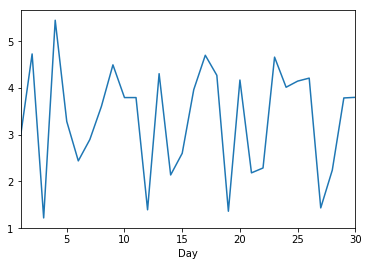

In [13]:
data.loc[ Clip1PrimeId + Clip1NonPrimeId ].groupby('Day')['BlockRate'].sum().plot();

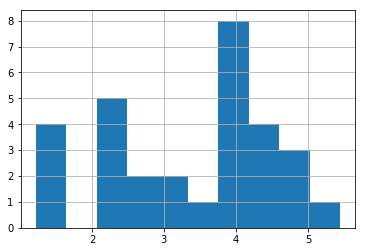

In [14]:
data.loc[ Clip1PrimeId + Clip1NonPrimeId ].groupby('Day')['BlockRate'].sum().hist();

In [15]:
print("Skewtest: ", skewtest(data.loc[ Clip1PrimeId + Clip1NonPrimeId ].groupby('Day')['BlockRate'].sum()))
print("Skew: ", skew(data.loc[ Clip1PrimeId + Clip1NonPrimeId ].groupby('Day')['BlockRate'].sum()))
print("Kurtosis: ", kurtosis(data.loc[ Clip1PrimeId + Clip1NonPrimeId ].groupby('Day')['BlockRate'].sum(), fisher=True))

Skewtest:  SkewtestResult(statistic=-0.9285575426049665, pvalue=0.35311843371651475)
Skew:  -0.3605654074995679
Kurtosis:  -0.9609535747722586


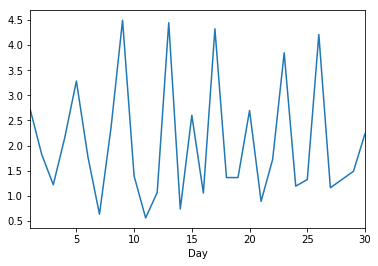

In [16]:
data.loc[ Clip2PrimeId + Clip2NonPrimeId ].groupby('Day')['BlockRate'].sum().plot();

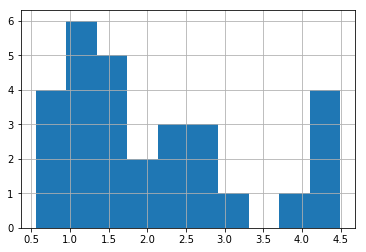

In [17]:
data.loc[ Clip2PrimeId + Clip2NonPrimeId ].groupby('Day')['BlockRate'].sum().hist();

In [18]:
print("Skewtest: ", skewtest(data.loc[ Clip2PrimeId + Clip2NonPrimeId ].groupby('Day')['BlockRate'].sum()))
print("Skew: ", skew(data.loc[ Clip2PrimeId + Clip2NonPrimeId ].groupby('Day')['BlockRate'].sum()))
print("Kurtosis: ", kurtosis(data.loc[ Clip2PrimeId + Clip2NonPrimeId ].groupby('Day')['BlockRate'].sum(), fisher=True))

Skewtest:  SkewtestResult(statistic=1.9475566675126597, pvalue=0.05146803297550784)
Skew:  0.810742265436533
Kurtosis:  -0.5663059847513665


### 2. Алгоритм В

Этот алгоритм идентичен предыдущему заисключением отсутсвия оптимизации по дням. В данном случае оптимизация происходит сразу по всему месяцу. Сильного смещения рейтингов в какие-то определенные периоды не происходит, наоборот, алгоритм выбирает самые оптимальные выходы на ТВ, которые натуральным образом распределены по всему месяцу.

In [19]:
def AdBlockSelector(Data, GRP, PrimeShare, IsPrime, ClipLen):

    """
    Description: select optimal 
    
    Parameters:
    """
    
    
    if IsPrime:
        ClipDayWeight = GRP * (PrimeShare)   #weak
    else:
        ClipDayWeight = GRP * (1-PrimeShare)   #weak

    BlockIdxToUse = []
    DayResid = 0

    
    
    ClipDayWeightAdj = ClipDayWeight - DayResid
    
    
    if ClipDayWeightAdj <= 0:
        DayResid = DayResid - ClipDayWeight
        
    

    
    else:
        BlockRateSorted = Data[(Data['IsPrime'] == IsPrime) & 
                                   (Data['AvailableSeconds'] >= ClipLen)].sort_values(
            ['Affinity'], ascending=False)['BlockRate']
    
        IndexMinDev = np.argmin( np.abs( BlockRateSorted.cumsum() - ClipDayWeightAdj ) )            
        DayResid = ( BlockRateSorted.cumsum() - ClipDayWeightAdj )[IndexMinDev]
        IndexMinDevPos = list(BlockRateSorted.index).index(IndexMinDev)
    
        BlockIdxToUse = list(BlockRateSorted.index)[:IndexMinDevPos + 1]

        Data.loc[BlockIdxToUse, 'AvailableSeconds'] = (Data.loc[BlockIdxToUse, 'AvailableSeconds'] 
                                                                  - ClipLen).values #clip#len
    
    return BlockIdxToUse

### 1.1. Задаем исходные параметры, загружаем датасет

In [20]:
Clip1Len = 30
Clip2Len = 30

Clip1GRP = 100
Clip2GRP = 60

Clip1PrimeShare = 0.59
Clip2PrimeShare = 0.49

PrimeCPP = 6
NonPrimeCPP = 3

#download the file
FILE = 'TvBreaksData_toSend.xlsx'
data = pd.read_excel(PATH + '\\' + FILE)

data['BlockDateTimeShifted'] = ( data['BlockDateTime'] - dt.timedelta(hours=6) )
data['Day'] = data['BlockDateTimeShifted'].dt.day
data['Affinity'] = (data['TargetRate'] / data['BlockRate'])

### 1.2. Запускаем функцию, получаем результаты

In [21]:
#collect blockid numbers by days of month for specific clip with prime option (off/on)
Clip1PrimeId = AdBlockSelector(Data=data, GRP=Clip1GRP, PrimeShare=Clip1PrimeShare, IsPrime=True, ClipLen=Clip1Len)
Clip1NonPrimeId = AdBlockSelector(Data=data, GRP=Clip1GRP, PrimeShare=Clip1PrimeShare, IsPrime=False, ClipLen=Clip1Len)
Clip2PrimeId = AdBlockSelector(Data=data, GRP=Clip2GRP, PrimeShare=Clip2PrimeShare, IsPrime=True, ClipLen=Clip1Len)
Clip2NonPrimeId = AdBlockSelector(Data=data, GRP=Clip2GRP, PrimeShare=Clip2PrimeShare, IsPrime=False, ClipLen=Clip1Len)

In [22]:
#CPP is a constant 
print("Spend RUR: ",
( (PrimeCPP * Clip1GRP * Clip1PrimeShare) + (NonPrimeCPP * Clip1GRP * (1-Clip1PrimeShare)) +
 (PrimeCPP * Clip2GRP * Clip2PrimeShare) + (NonPrimeCPP * Clip2GRP * (1-Clip2PrimeShare)) ) )

Spend RUR:  745.1999999999999


In [23]:
print("Num of Spots",
( len( Clip1PrimeId ) * PrimeCPP +
 len( Clip1NonPrimeId ) * NonPrimeCPP +
 len( Clip2PrimeId ) * PrimeCPP +
 len( Clip2NonPrimeId ) * NonPrimeCPP ) )

Num of Spots 813


In [24]:
print("Clip1 Prime BlockRate: ", 
      data.loc[ Clip1PrimeId ]['BlockRate'].sum(),
      "Clip1 Prime TargetRate: ", 
      data.loc[ Clip1PrimeId ]['TargetRate'].sum())

print("Clip1 NonPrime BlockRate: ", 
      data.loc[ Clip1NonPrimeId ]['BlockRate'].sum(),
      "Clip1 NonPrime TargetRate: ", 
      data.loc[ Clip1NonPrimeId ]['TargetRate'].sum())

print("Clip2 Prime BlockRate: ", 
      data.loc[ Clip2PrimeId ]['BlockRate'].sum(),
      "Clip1 Prime TargetRate: ", 
      data.loc[ Clip2PrimeId ]['TargetRate'].sum())

print("Clip2 NonPrime BlockRate: ", 
      data.loc[ Clip2NonPrimeId ]['BlockRate'].sum(),
      "Clip1 NonPrime TargetRate: ", 
      data.loc[ Clip2NonPrimeId ]['TargetRate'].sum())

Clip1 Prime BlockRate:  58.672000000000004 Clip1 Prime TargetRate:  112.91083587076645
Clip1 NonPrime BlockRate:  40.794000000000004 Clip1 NonPrime TargetRate:  78.2418899161879
Clip2 Prime BlockRate:  29.706999999999997 Clip1 Prime TargetRate:  59.43558902195562
Clip2 NonPrime BlockRate:  30.730999999999998 Clip1 NonPrime TargetRate:  60.565301015435146


In [25]:
print("GRP to buy: ", 
      data.loc[ Clip1PrimeId ]['BlockRate'].sum()  +
      data.loc[ Clip1NonPrimeId ]['BlockRate'].sum()  +
      data.loc[ Clip2PrimeId ]['BlockRate'].sum()  +
      data.loc[ Clip2NonPrimeId ]['BlockRate'].sum(),
     "   Plan: 160")

GRP to buy:  159.904    Plan: 160


In [26]:
print("Target Rate: ", 
      data.loc[ Clip1PrimeId ]['TargetRate'].sum()  +
      data.loc[ Clip1NonPrimeId ]['TargetRate'].sum()  +
      data.loc[ Clip2PrimeId ]['TargetRate'].sum()  +
      data.loc[ Clip2NonPrimeId ]['TargetRate'].sum())

Target Rate:  311.15361582434514


In [27]:
print("Actual Spend RUR: ", 
      data.loc[ Clip1PrimeId ]['BlockRate'].sum() * PrimeCPP +
      data.loc[ Clip1NonPrimeId ]['BlockRate'].sum() * NonPrimeCPP +
      data.loc[ Clip2PrimeId ]['BlockRate'].sum() * PrimeCPP +
      data.loc[ Clip2NonPrimeId ]['BlockRate'].sum() * NonPrimeCPP,
     "   Plan: 750")

Actual Spend RUR:  744.849    Plan: 750


### 1.3. Небольшая проверка на нормальность распределения

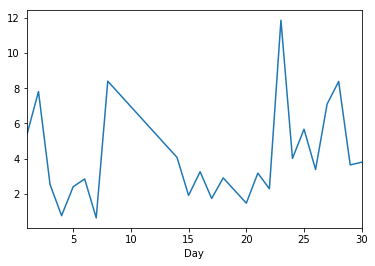

In [28]:
data.loc[ Clip1PrimeId + Clip1NonPrimeId ].groupby('Day')['BlockRate'].sum().plot();

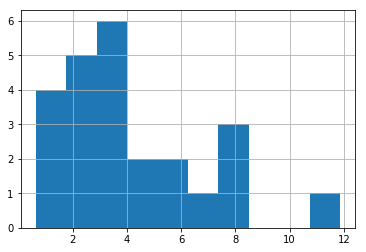

In [29]:
data.loc[ Clip1PrimeId + Clip1NonPrimeId ].groupby('Day')['BlockRate'].sum().hist();

In [30]:
print("Skewtest: ", skewtest(data.loc[ Clip1PrimeId + Clip1NonPrimeId ].groupby('Day')['BlockRate'].sum()))
print("Skew: ", skew(data.loc[ Clip1PrimeId + Clip1NonPrimeId ].groupby('Day')['BlockRate'].sum()))
print("Kurtosis: ", kurtosis(data.loc[ Clip1PrimeId + Clip1NonPrimeId ].groupby('Day')['BlockRate'].sum(), fisher=True))

Skewtest:  SkewtestResult(statistic=2.409124309773092, pvalue=0.015990850269967372)
Skew:  1.1226415272058399
Kurtosis:  0.6923522725379168


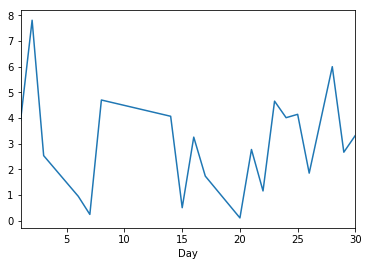

In [31]:
data.loc[ Clip2PrimeId + Clip2NonPrimeId ].groupby('Day')['BlockRate'].sum().plot();

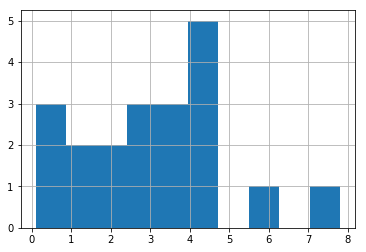

In [32]:
data.loc[ Clip2PrimeId + Clip2NonPrimeId ].groupby('Day')['BlockRate'].sum().hist();

In [33]:
print("Skewtest: ", skewtest(data.loc[ Clip2PrimeId + Clip2NonPrimeId ].groupby('Day')['BlockRate'].sum()))
print("Skew: ", skew(data.loc[ Clip2PrimeId + Clip2NonPrimeId ].groupby('Day')['BlockRate'].sum()))
print("Kurtosis: ", kurtosis(data.loc[ Clip2PrimeId + Clip2NonPrimeId ].groupby('Day')['BlockRate'].sum(), fisher=True))

Skewtest:  SkewtestResult(statistic=1.031364942386105, pvalue=0.3023697144408103)
Skew:  0.46860991258914203
Kurtosis:  -0.06894892760541227


### 3. Результаты

**Алгоритм В** показал отличные результаты, которые превосходят **алгоритм А (311 > 287 Target Rate)**, при этом распределение рейтингов внутри месяца имеет равномерный вид. Стратегия аккуратного распределения рейтингов внутри каждого дня с т.з. нормальности распределения и результата целевой функции не оправдывает себя. 

*P.S. стоит отметить, что общая сумма размещения при использовании алгоритма В будет на 5.151 рубль меньше (744.849) допустимого (750)* 